In [3]:
# TODO: further enhance preprocessing

# TODO: Attention and group norm
# TODO: one step further compression
# TODO: test with grid paper on inference
# TODO: test freezing different segments of the autoencoder
# TODO: test by training on abnormal brains from dHCP then compare w normals
# TODO: try classification task mimicking BRATS model (how to get novelty detection)
#       could try training on healthy first then freeze compression and add classification
# TODO: look at volumetric differences/register back to original image after modeling
# TODO: z-score comparison pre/post model

### Import Libraries

In [1]:
%matplotlib inline

import nibabel as nib
import ants
import numpy as np
import pandas as pd
import os
from math import ceil
import multiprocessing as mp
import re

from nilearn.image import load_img, smooth_img, resample_img, get_data
from nilearn.plotting import show, view_img, plot_img
import intensity_normalization.normalize as norm

import matplotlib.pyplot as plt
from PIL import Image
from skimage.measure import compare_ssim
import imutils
import cv2
import scipy

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import (
    Conv3D,
    MaxPooling3D,
    Conv3DTranspose,
    UpSampling3D,
    BatchNormalization,
    Activation,
    Add,
    Input,
    Lambda,
    Dense
)
from tensorflow.keras.utils import plot_model
import tensorflow.keras.losses as losses
from tensorflow_addons.layers import InstanceNormalization

### Define Paths

In [5]:
research_dir = '/media/jraad/Data1/school/research/'
data_dir = os.path.join(research_dir, 'data')
dhcp_dir = os.path.join(data_dir, 'dHCP')
dhcp_norm = os.path.join(dhcp_dir, 'normalized')

chm_dir = os.path.join(data_dir, 'chm')
chm_norm = os.path.join(chm_dir, 'normalized')

### Read and Scale Data

In [19]:
x, y, z = (256, 256, 256)
# x, y, z = (128, 128, 128)
max_intensity = 0

# Read Normal brains
original_samples = []
samples = []
counter = 0
file_list = os.listdir(img_dir)
file_list = sorted(file_list)
ref_img = None
for file in file_list:
#     radiology_score = re.search('(?<=\_)(.*?)(?=\.)', file).group(0)
#     if radiology_score == '1':
    file_path = os.path.join(img_dir, file)
    img = ants.image_read(file_path)
    if img.shape == (290, 290, 203):
        print(f"processing image {counter}, {file}")
        counter += 1
        original_samples.append(img.numpy())
        if counter == 15:
            break
#             if counter == 0:
#                 img = ants.n3_bias_field_correction(img)
#                 img = ants.resample_image(img, (x, y, z), True, 1)
#                 ref_img = img
#                 samples.append(img.numpy())
#             else:
#                 img = ants.n3_bias_field_correction(img)
#                 img = ants.resample_image(img, (x, y, z), True, 1)
#                 img = ants.registration(fixed=ref_img, moving=img, type_of_transform='SyN')
#                 samples.append(img['warpedmovout'].numpy())
#             

processing image 0, sub-CC00058XX09_ses-11300_desc-restore_T2w.nii.gz
processing image 1, sub-CC00060XX03_ses-12501_desc-restore_T2w.nii.gz
processing image 2, sub-CC00062XX05_ses-13801_desc-restore_T2w.nii.gz
processing image 3, sub-CC00063AN06_ses-15102_desc-restore_T2w.nii.gz
processing image 4, sub-CC00065XX08_ses-18600_desc-restore_T2w.nii.gz
processing image 5, sub-CC00066XX09_ses-19200_desc-restore_T2w.nii.gz
processing image 6, sub-CC00067XX10_ses-20200_desc-restore_T2w.nii.gz
processing image 7, sub-CC00068XX11_ses-20701_desc-restore_T2w.nii.gz
processing image 8, sub-CC00069XX12_ses-26300_desc-restore_T2w.nii.gz
processing image 9, sub-CC00070XX05_ses-26700_desc-restore_T2w.nii.gz
processing image 10, sub-CC00071XX06_ses-27000_desc-restore_T2w.nii.gz
processing image 11, sub-CC00072XX07_ses-27600_desc-restore_T2w.nii.gz
processing image 12, sub-CC00073XX08_ses-27800_desc-restore_T2w.nii.gz
processing image 13, sub-CC00074XX09_ses-28000_desc-restore_T2w.nii.gz
processing image

### Write Out Preprocessed Data

In [4]:
# np.save(preproc_dir, samples)

### Read Preprocessed Data

In [6]:
dhcp_healty = os.path.join(dhcp_norm, 'dhcp_level1.npy')
samples = np.load(dhcp_healty)

### Visualize Resampled Images

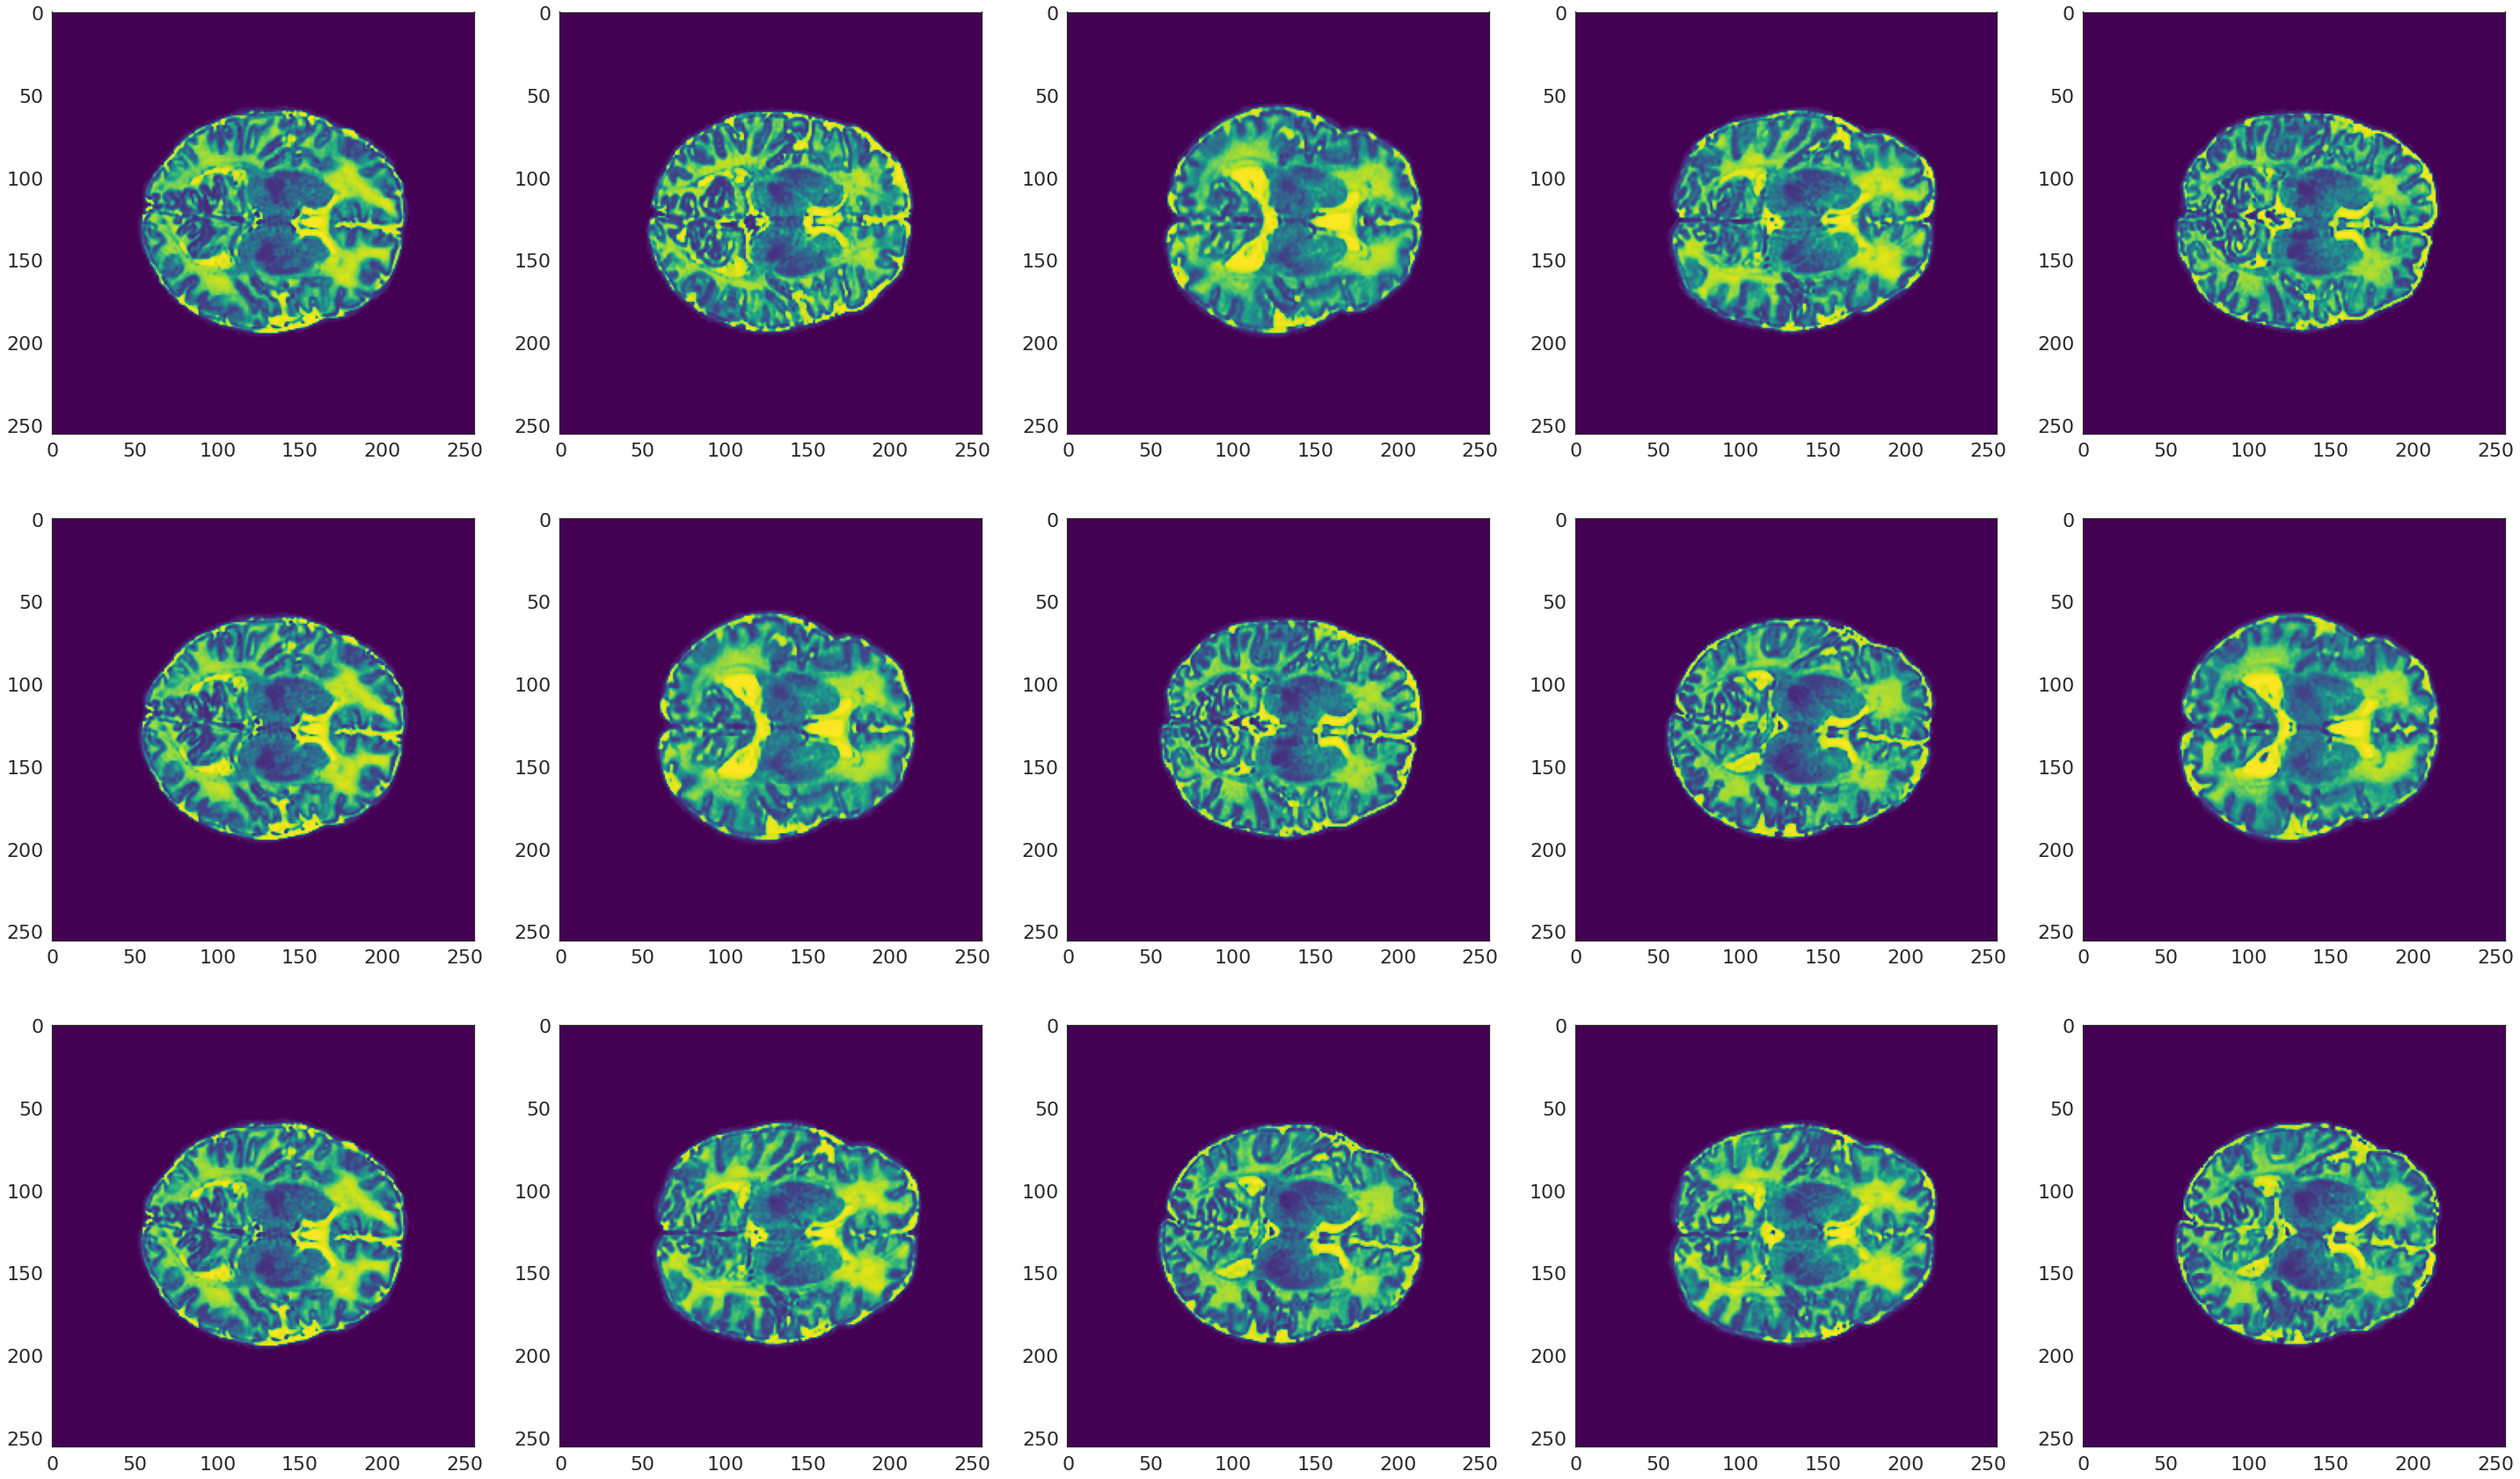

In [7]:
%matplotlib inline

f, axarr = plt.subplots(3, 5, figsize=(50,30))
cmap = plt.get_cmap('viridis')

for r in range(0,3):
    for i in range(0, 5):
        z = ceil(samples[i*(r+1)].shape[2]/2)
        axarr[r][i].imshow(samples[i*(r+1)][:,:,z], cmap=cmap)

### Prepare Data for Modeling

In [13]:
(x, y, z) = samples[0].shape
train = []

for img in samples[0:100]:
    train.append(np.reshape(img, (x, y, z, 1)))
    
train = np.asarray(train)

### Define ResNet Block

In [15]:
def resnet_encoder(in_val):
    kernel_size = (3, 3, 3)
    strides = (2, 2, 2)
    padding = 'same'
    
    # First block
    x = InstanceNormalization()(in_val)
    x = Activation('relu')(x)
    x = Conv3D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)
    
     # Second block
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)

    # Bypass
    x_bypass = Conv3D(
        filters=32,
        kernel_size=kernel_size,
        strides=(4, 4, 4),
        padding=padding
    )(in_val)
    x = Add()([x, x_bypass])
    x = Activation('relu')(x)
    
    return x

def resnet_encoder_half(in_val):
    kernel_size = (3, 3, 3)
    strides = (2, 2, 2)
    padding = 'same'
    
    # First block
    x = InstanceNormalization()(in_val)
    x = Activation('relu')(x)
    x = Conv3D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)

    # Bypass
    x_bypass = Conv3D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(in_val)
    x = Add()([x, x_bypass])
    x = Activation('relu')(x)
    
    return x

    
def resnet_decoder(in_val):
    kernel_size = (3, 3, 3)
    strides = (2, 2, 2)
    padding = 'same'
    
    # First block
    x = InstanceNormalization()(in_val)
    x = Activation('relu')(x)
    x = Conv3DTranspose(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)
    
    # Second block
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3DTranspose(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)
    
    # Bypass
    x_bypass = Conv3DTranspose(
        filters=32,
        kernel_size=kernel_size,
        strides=(4, 4, 4),
        padding=padding
    )(in_val)
    x = Add()([x, x_bypass])
    x = Activation('relu')(x)
    
    return x

def resnet_decoder_half(in_val):
    kernel_size = (3, 3, 3)
    strides = (2, 2, 2)
    padding = 'same'
    
    # First block
    x = InstanceNormalization()(in_val)
    x = Activation('relu')(x)
    x = Conv3DTranspose(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(x)
    
    # Bypass
    x_bypass = Conv3DTranspose(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(in_val)
    x = Add()([x, x_bypass])
    x = Activation('relu')(x)
    
    return x

### Define Model

In [16]:
# input
in_layer = Input((x, y, z, 1))

# encoder
a = resnet_encoder(in_layer)
a = resnet_encoder(a)

# decoder
a = resnet_decoder(a)
a = resnet_decoder(a)

# transform final layer
a = Conv3DTranspose(
    filters=1,
    kernel_size=(3, 3, 3),
    padding='same'
)(a)


model = Model(in_layer, a)
model.summary(positions=[.2, .55, .67, 1.])

# compile
# loss = losses.kullback_leibler_divergence
loss = 'mse'
optimizer = 'adam'
model.compile(
    optimizer=optimizer,
    loss=loss
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)       Output Shape                      Param #     Connected to                     
input_1 (InputLaye [(None, 256, 256, 32, 1)]         0                                            
__________________________________________________________________________________________________
instance_normaliza (None, 256, 256, 32, 1)           2           input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activa (None, 256, 256, 32, 1)           0           instance_normalization[0][0]     
__________________________________________________________________________________________________
conv3d (Conv3D)    (None, 128, 128, 16, 32)          896         activation[0][0]                 
______________________________________________________________________________________________

### Train Model

In [17]:
model.fit(
    train,
    train,
    batch_size=1,
    epochs=150,
    verbose=1,
)

# save model
# model_json = model.to_json()
# flat_json_dir = os.path.join(model_dir, '3d_model_dhcp_weird.json')
# flat_model_dir = os.path.join(model_dir, '3d_model_dhcp_weird.h5')

# with open(flat_json_dir, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(flat_model_dir)

Epoch 1/150
100/100 [==============================] - 7s 73ms/step - loss: 0.0201
Epoch 2/150
100/100 [==============================] - 7s 74ms/step - loss: 0.0119
Epoch 3/150
100/100 [==============================] - 7s 73ms/step - loss: 0.0107
Epoch 4/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0099
Epoch 5/150
100/100 [==============================] - 7s 73ms/step - loss: 0.0094
Epoch 6/150
100/100 [==============================] - 7s 73ms/step - loss: 0.0090
Epoch 7/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0088
Epoch 8/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0086
Epoch 9/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0085
Epoch 10/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0084
Epoch 11/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0082
Epoch 12/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0081
E

100/100 [==============================] - 7s 69ms/step - loss: 0.0065
Epoch 99/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0064
Epoch 100/150
100/100 [==============================] - 7s 74ms/step - loss: 0.0065
Epoch 101/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0065
Epoch 102/150
100/100 [==============================] - 7s 67ms/step - loss: 0.0065
Epoch 103/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0064
Epoch 104/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0064
Epoch 105/150
100/100 [==============================] - 7s 68ms/step - loss: 0.0064
Epoch 106/150
100/100 [==============================] - 7s 67ms/step - loss: 0.0064
Epoch 107/150
100/100 [==============================] - 7s 68ms/step - loss: 0.0064
Epoch 108/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0064
Epoch 109/150
100/100 [==============================] - 7s 70ms/step - loss: 0.

In [14]:
model_json = model.to_json()
flat_json_dir = os.path.join(model_dir, '3d_model_dhcp_preproc.json')
flat_model_dir = os.path.join(model_dir, '3d_model_dhcp_preproc.h5')

with open(flat_json_dir, "w") as json_file:
    json_file.write(model_json)
model.save_weights(flat_model_dir)

### Load Model

In [3]:
# load model
flat_json_dir = os.path.join(model_dir, '3d_model_dhcp_preproc.json')
flat_model_dir = os.path.join(model_dir, '3d_model_dhcp_preproc.h5')
json_file = open(flat_json_dir, 'r')
model = model_from_json(json_file.read())
json_file.close()
model.load_weights(flat_model_dir)

In [8]:
before_path = os.path.join(data_dir, 'before_diff.npy')
np.save(before_path, train[0])

after_path = os.path.join(data_dir, 'after_diff.npy')
np.save(after_path, pred_img)

### Diff Viz Function

In [18]:
from math import ceil
from matplotlib.colors import LinearSegmentedColormap

def diff_image_viz(before, after, bins):    
    x, y, z = before.shape
    z_plot = ceil(z / 2)
    diff = before - after
    
    mean = np.mean(diff)
    std = np.std(diff)
    
    print(std)

    diff_scaled = (diff - mean) / std
    
    diff_scaled[abs(diff_scaled) <= 2] = 0
    diff_scaled = abs(diff_scaled)
    #diff_scaled[diff_scaled != 0] = 2
    
    colors = [(0, 0, 0, 0), (0.5, 0, 0, 1), (0.6, 0, 0, 1), (0.8, 0, 0, 1), (1, 0, 0, 1)]
    cmap_name = 'mri_diff'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=bins)
    
    fig, axs = plt.subplots(1, 1, figsize=(30, 30))
    
    plt.imshow(before[:,:,z_plot], cmap='viridis')
    plt.imshow(np.reshape(diff_scaled[:,:,z_plot], (x, y)), cmap=cm)
    plt.colorbar()

### Display Predicted Image

Text(0.5, 1.0, 'Recreated')

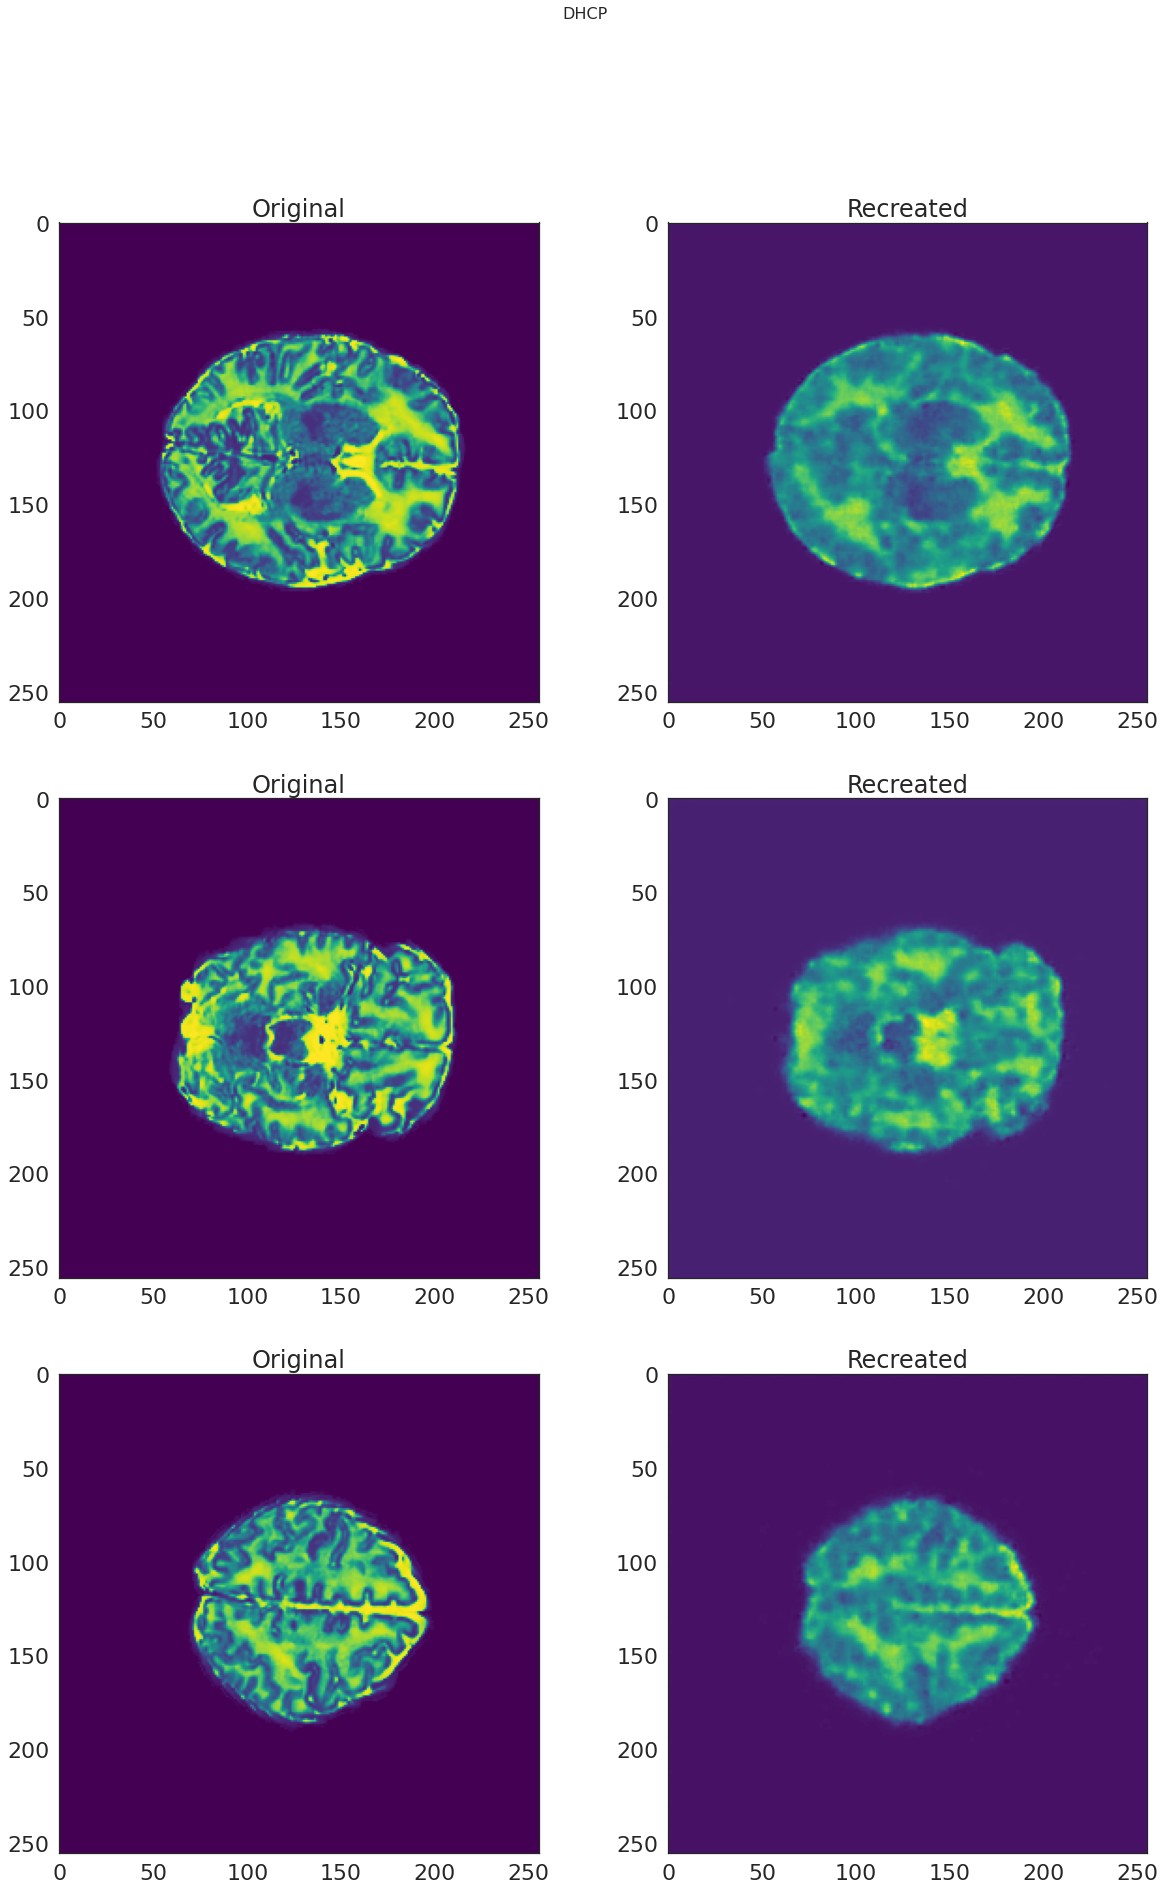

In [19]:
## predict image
pred_img = model.predict(np.reshape(train[0], (1, x, y, z, 1)))
pred_img = np.reshape(pred_img, (x, y, z))

# plot original and new image
f, axarr = plt.subplots(3, 2, figsize=(20,30))
cmap = plt.get_cmap('viridis')

z_plot = ceil(pred_img.shape[2]/2)
f.suptitle('DHCP', fontsize=16)
axarr[0][0].imshow(np.reshape(train[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0][0].set_title('Original')
axarr[0][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[0][1].set_title('Recreated')

z_plot = ceil(pred_img.shape[2]/4)
axarr[1][0].imshow(np.reshape(train[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[1][0].set_title('Original')
axarr[1][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1][1].set_title('Recreated')

# Normal
z_plot = ceil(pred_img.shape[2]/2) + 10
axarr[2][0].imshow(np.reshape(train[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[2][0].set_title('Original')
axarr[2][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[2][1].set_title('Recreated')

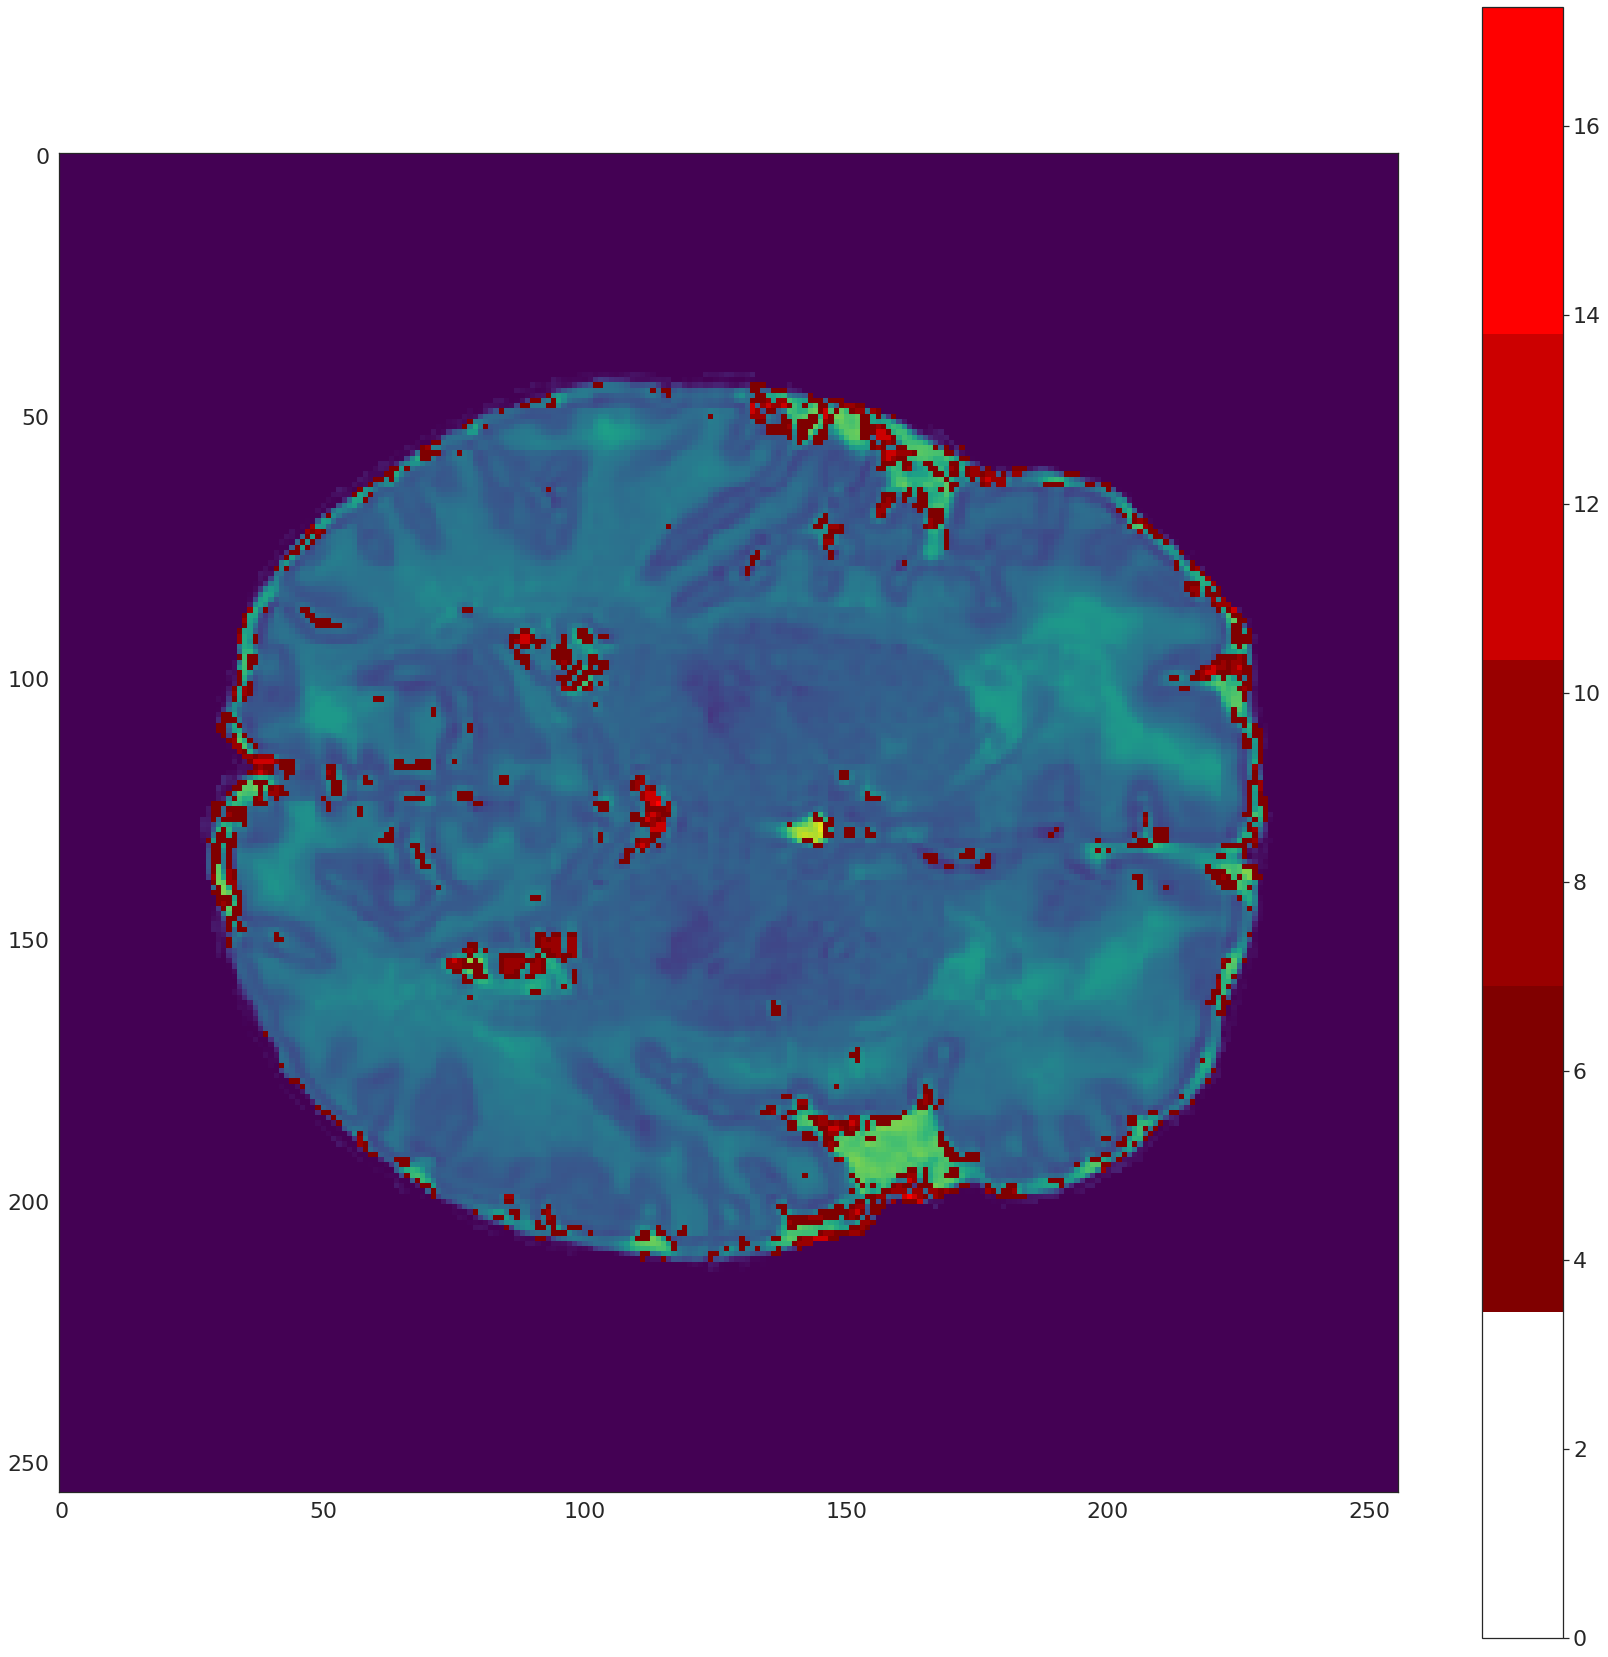

In [12]:
x = y = z = 256
diff_image_viz(np.reshape(train[0], (x, y, z)), pred_img, 5)

Text(0.5, 1.0, 'Recreated')

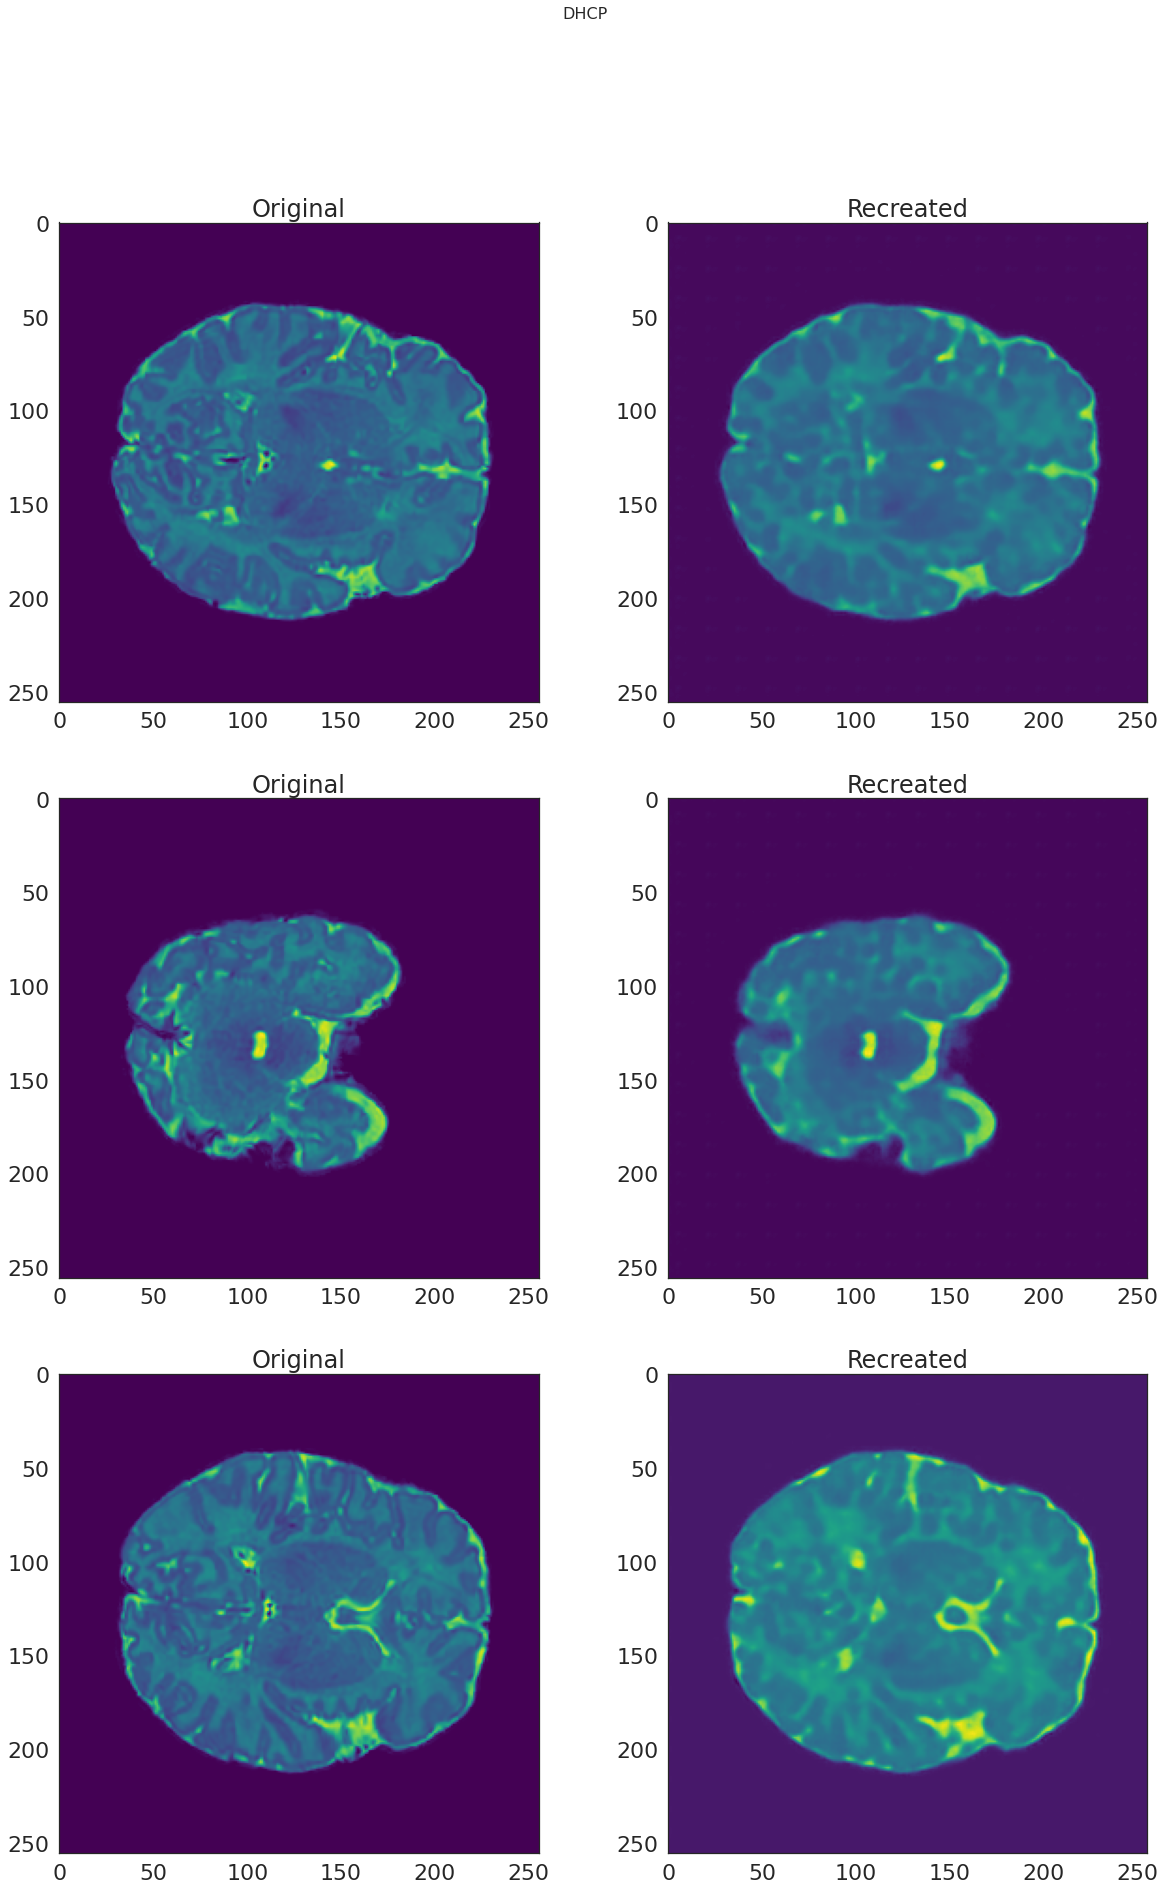

In [40]:
index = 1
## predict image
pred_img = model.predict(np.reshape(train[index], (1, x, y, z, 1)))
pred_img = np.reshape(pred_img, (x, y, z))

# plot original and new image
f, axarr = plt.subplots(3, 2, figsize=(20,30))
cmap = plt.get_cmap('viridis')


z_plot = ceil(pred_img.shape[2]/2)
f.suptitle('DHCP', fontsize=16)
axarr[0][0].imshow(np.reshape(train[index][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0][0].set_title('Original')
axarr[0][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[0][1].set_title('Recreated')

z_plot = ceil(pred_img.shape[2]/4)
axarr[1][0].imshow(np.reshape(train[index][:,:,z_plot], (x, y)), cmap=cmap)
axarr[1][0].set_title('Original')
axarr[1][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1][1].set_title('Recreated')

# Normal
z_plot = ceil(pred_img.shape[2]/2) + 10
axarr[2][0].imshow(np.reshape(train[index][:,:,z_plot], (x, y)), cmap=cmap)
axarr[2][0].set_title('Original')
axarr[2][1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[2][1].set_title('Recreated')

In [46]:
z_plot = ceil(pred_img.shape[2]/2) + 10
res = np.reshape(train[index][:,:,z_plot], (x, y))
print(res)
print(np.amin(res))
print(np.amax(res))

[[0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]
 [0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]
 [0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]
 ...
 [0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]
 [0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]
 [0.0312302 0.0312302 0.0312302 ... 0.0312302 0.0312302 0.0312302]]
0.031230196073275093
0.6697796697356673


In [47]:
res = pred_img[:,:,z_plot]
print(res)
print(np.amin(res))
print(np.amax(res))

[[0.02401129 0.02423676 0.02421989 ... 0.02433477 0.02367927 0.02418102]
 [0.02452126 0.02444552 0.02421989 ... 0.02462235 0.02405002 0.02427842]
 [0.02421989 0.02421989 0.02421989 ... 0.02421989 0.02421989 0.02421989]
 ...
 [0.02422179 0.02426528 0.02421989 ... 0.02421989 0.02421989 0.02421989]
 [0.02421394 0.02423485 0.02421989 ... 0.02421989 0.02421989 0.02421989]
 [0.02421989 0.02421989 0.02421989 ... 0.02421989 0.02421989 0.02421989]]
-0.015252499
0.58421487


### Test on Anomalous Data

In [4]:
preproc_dir5 = os.path.join(data_dir, 'preprocessed_5.npy')
samples5 = np.load(preproc_dir5)

X = []
x = y = z = 256


scale = np.load(os.path.join(data_dir, 'scale.npy'))
percs = np.load(os.path.join(data_dir, 'percs.npy'))

def normalize_images(images, scale, percs):
    samples_new = []
    for im in images:
        img = nib.Nifti1Image(im , np.eye(4))
        img_norm = norm.nyul.do_hist_norm(img, percs, scale, mask=None)
        samples_new.append(img_norm.get_fdata())
    return samples_new

def scale_images(images):
    im_min = np.amin(images)
    im_max = np.amax(images)
    
    return (images - im_min) / (im_max - im_min)

samples5 = normalize_images(samples5, scale, percs)
samples5 = scale_images(samples5)

num_unhealthy = samples5.shape[0]
for img in samples5:
    X.append(np.reshape(img, (x, y, z, 1)))

X = np.asarray(X)

In [5]:
x_pred = model.predict(X[0:2], batch_size=1)

In [14]:
cmap = plt.get_cmap('viridis')

### Display Anomalous Data

Text(0.5, 1.0, 'Recreated')

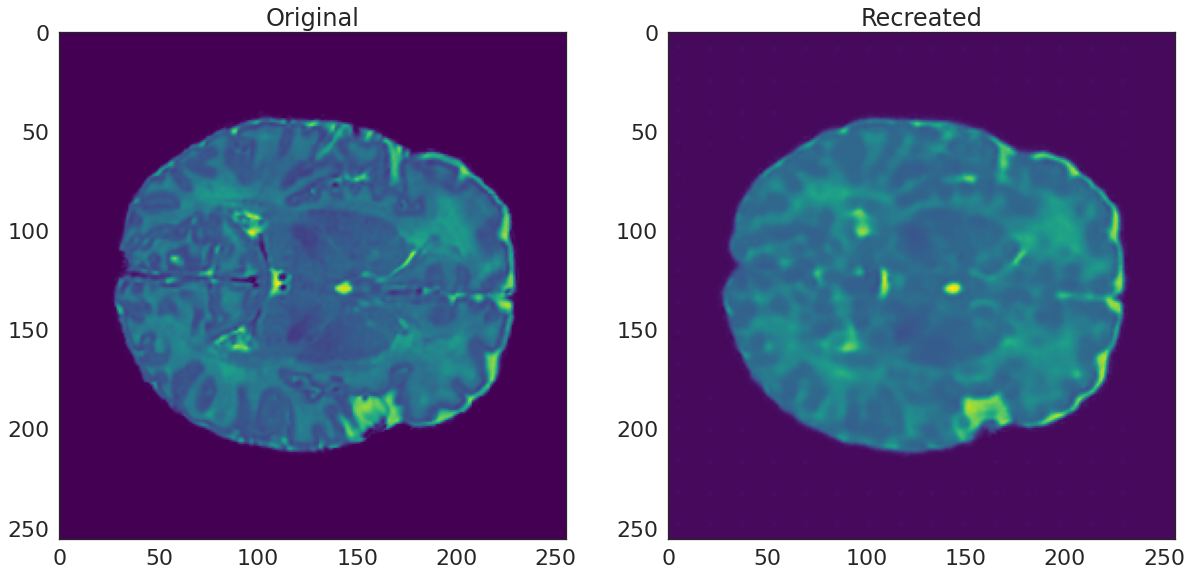

In [10]:
index = 1
# predict image
pred_img = np.reshape(x_pred[index], (x, y, z))

# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,10))
cmap = plt.get_cmap('viridis')

z_plot = ceil(pred_img.shape[2]/2)
# f.suptitle('CHM - Normal', fontsize=16)
axarr[0].imshow(np.reshape(samples5[index][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1].set_title('Recreated')

Text(0.5, 1.0, 'Recreated')

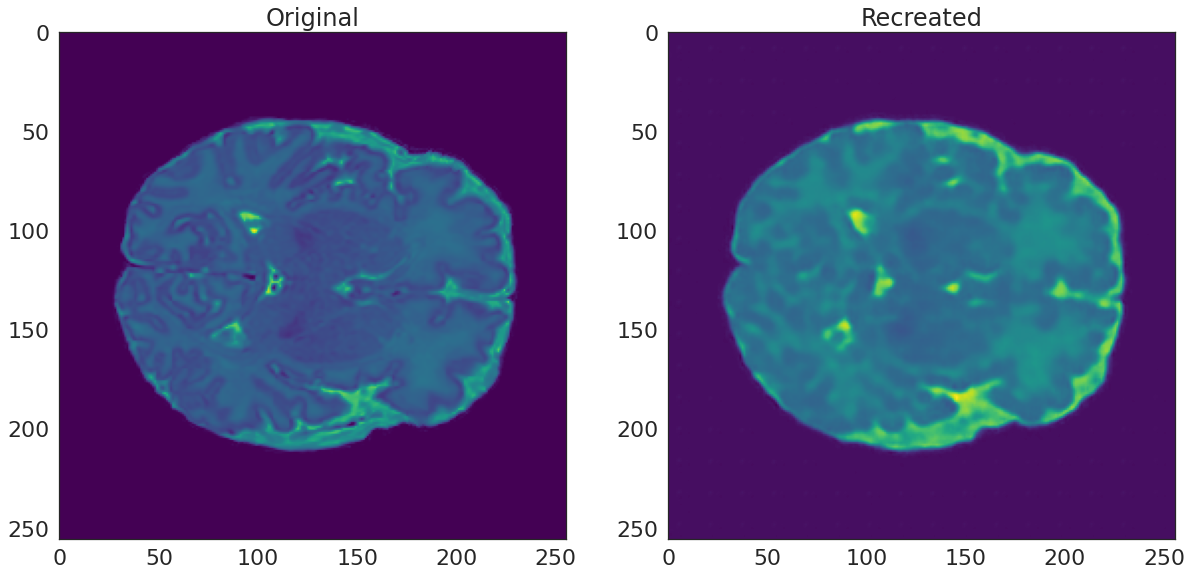

In [6]:

# predict image
pred_img = np.reshape(x_pred[0], (x, y, z))

# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,10))
cmap = plt.get_cmap('viridis')

z_plot = ceil(pred_img.shape[2]/2)
# f.suptitle('CHM - Normal', fontsize=16)
axarr[0].imshow(np.reshape(samples5[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1].set_title('Recreated')

0.023242059857976873


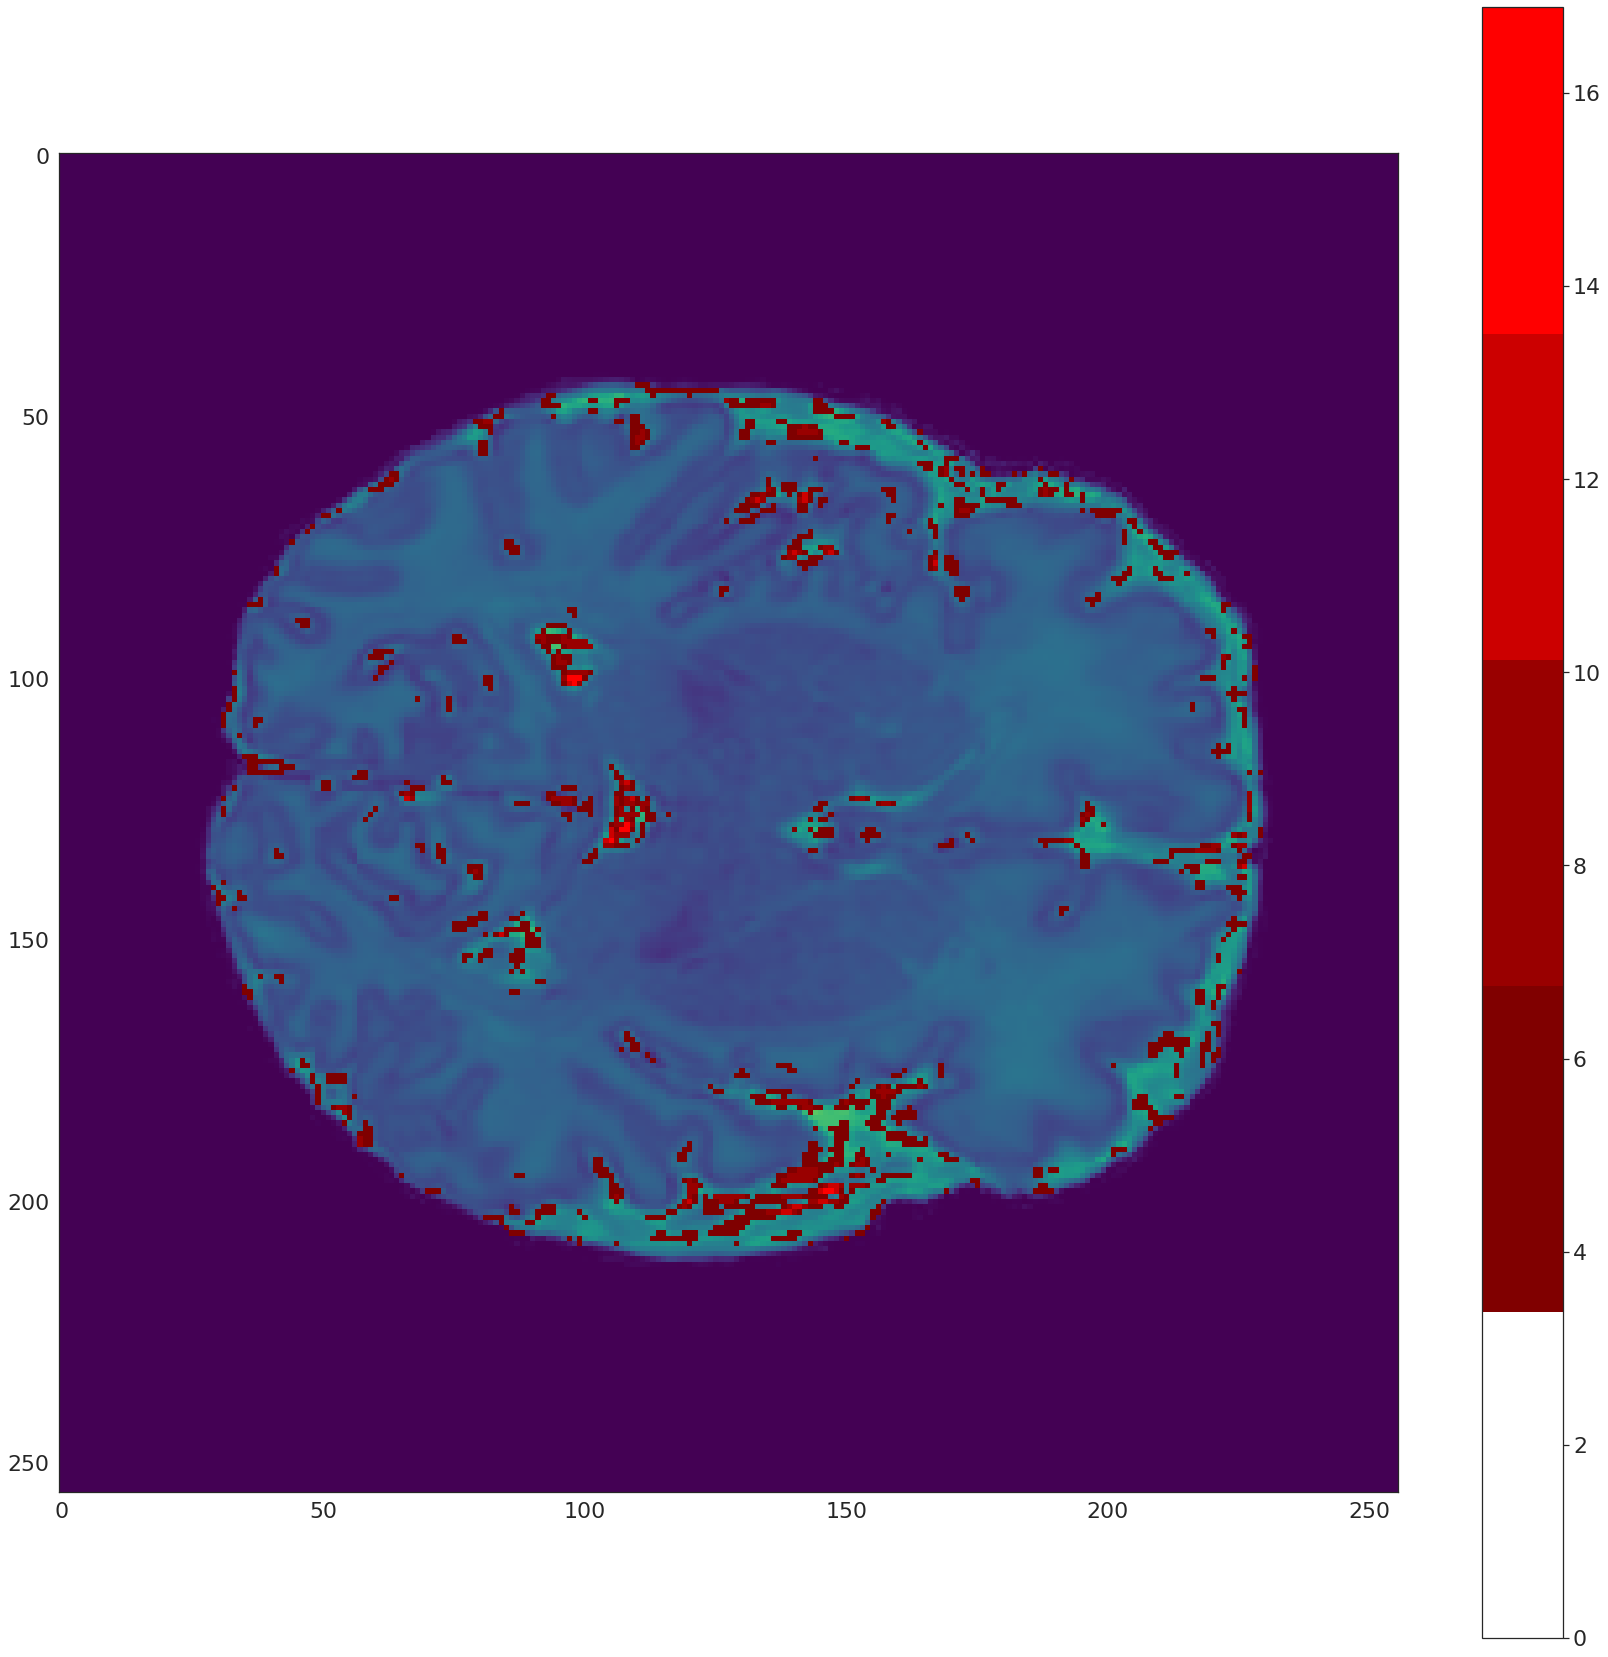

In [8]:
diff_image_viz(np.reshape(samples5[0], (x, y, z)), pred_img, 5)

### Display Cat Image

Text(0.5, 1.0, 'Recreated')

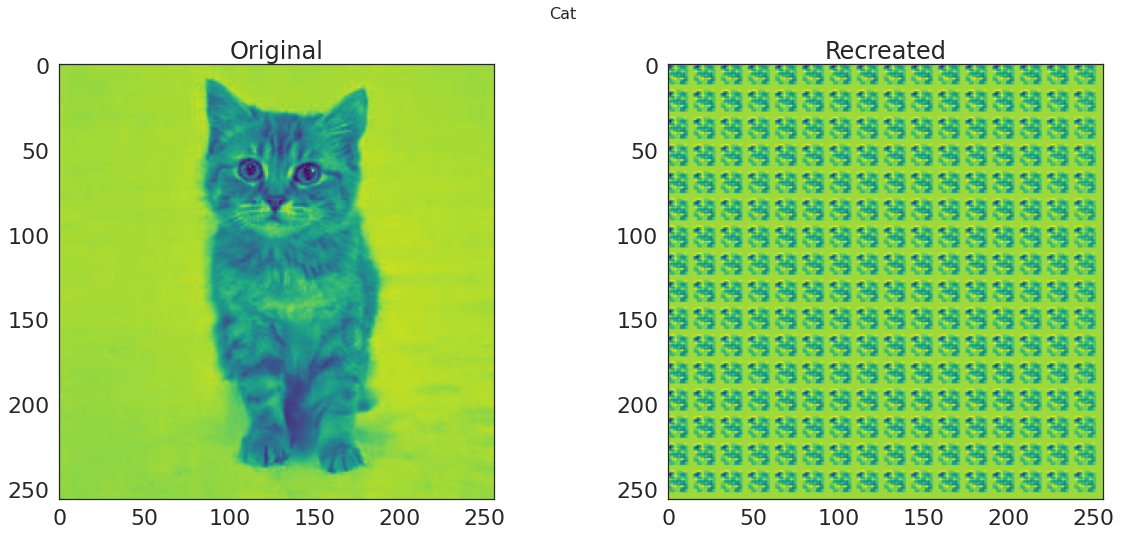

In [22]:
# read image
x, y, z = (256, 256, 32)
cat_path = '/media/jraad/Data1/school/research/data/cat_256.jpg'
cat_img_in = Image.open(cat_path).convert('L')
cat_img = np.reshape(np.asarray(cat_img_in), (256, 256))
cat_img = np.tile(cat_img, (z, 1, 1))
cat_img = np.reshape(cat_img, (1, x, y, z, 1))

# predict image
pred_img = model.predict(cat_img)
pred_img = np.reshape(pred_img, (x, y, z))


# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,8))

# Normal
f.suptitle('Cat', fontsize=16)
axarr[0].imshow(np.asarray(cat_img_in), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:, :, 16], cmap=cmap)
axarr[1].set_title('Recreated')

### Read CHM Data

In [23]:
InstanceNormalization# normal = []
# for folder_name in os.listdir(normal_dir):
#     img_path = os.path.join(normal_dir, folder_name, 'wT2_anonymous.nii')
#     img = ants.image_read(img_path)
#     img = ants.resample_image(img, (x, y, z), True, 1)
#     normal.append(img.numpy())

# abnormal = []
# for folder_name in os.listdir(abnormal_dir):
#     img_path = os.path.join(abnormal_dir, folder_name, 'wT2_anonymous.nii')
#     img = ants.image_read(img_path)
#     img = ants.resample_image(img, (x, y, z), True, 1)
#     abnormal.append(img.numpy())

# death = []
# for folder_name in os.listdir(death_dir):
#     img_path = os.path.join(death_dir, folder_name, 'wT2_anonymous.nii')
#     img = ants.image_read(img_path)
#     img = ants.resample_image(img, (x, y, z), True, 1)
#     death.append(img.numpy())

normal = np.load(os.path.join(chm_norm, 'chm_normal.npy'))
abnormal = np.load(os.path.join(chm_norm, 'chm_abnormal.npy'))
death = np.load(os.path.join(chm_norm, 'chm_death.npy'))

### Test on CHM Data

Text(0.5, 1.0, 'Recreated')

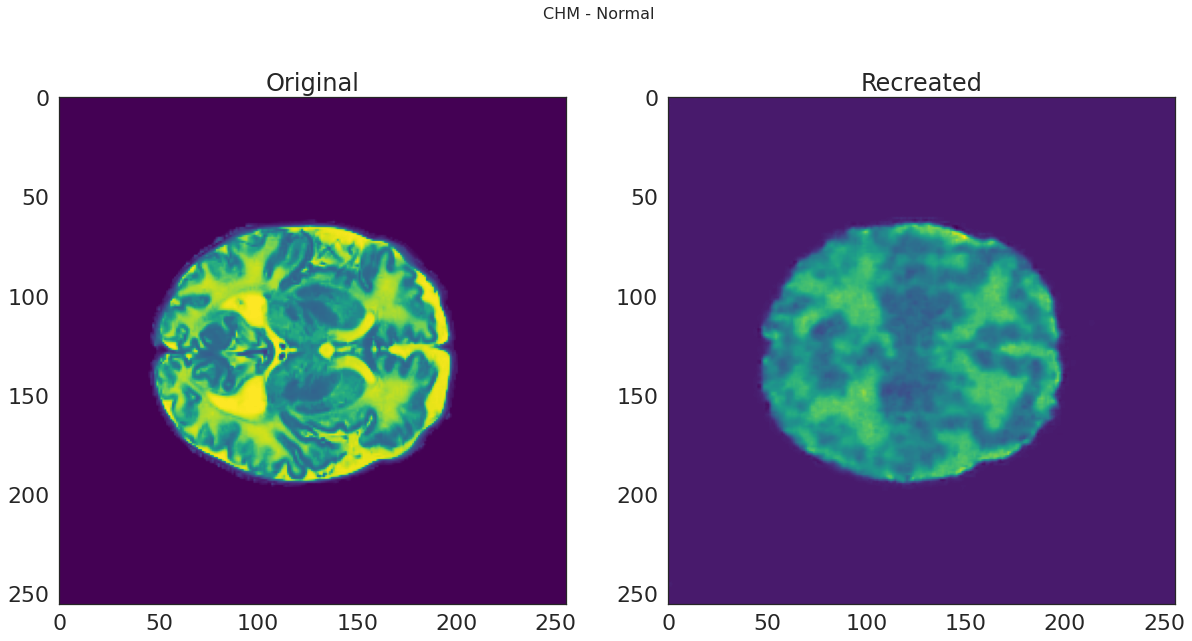

In [25]:
# predict image
pred_img = model.predict(np.reshape(normal[0], (1, x, y, z, 1)))
pred_img = np.reshape(pred_img, (x, y, z))

# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,10))

z_plot = ceil(pred_img.shape[2]/2)
f.suptitle('CHM - Normal', fontsize=16)
axarr[0].imshow(np.reshape(normal[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1].set_title('Recreated')

0.06442785730938522


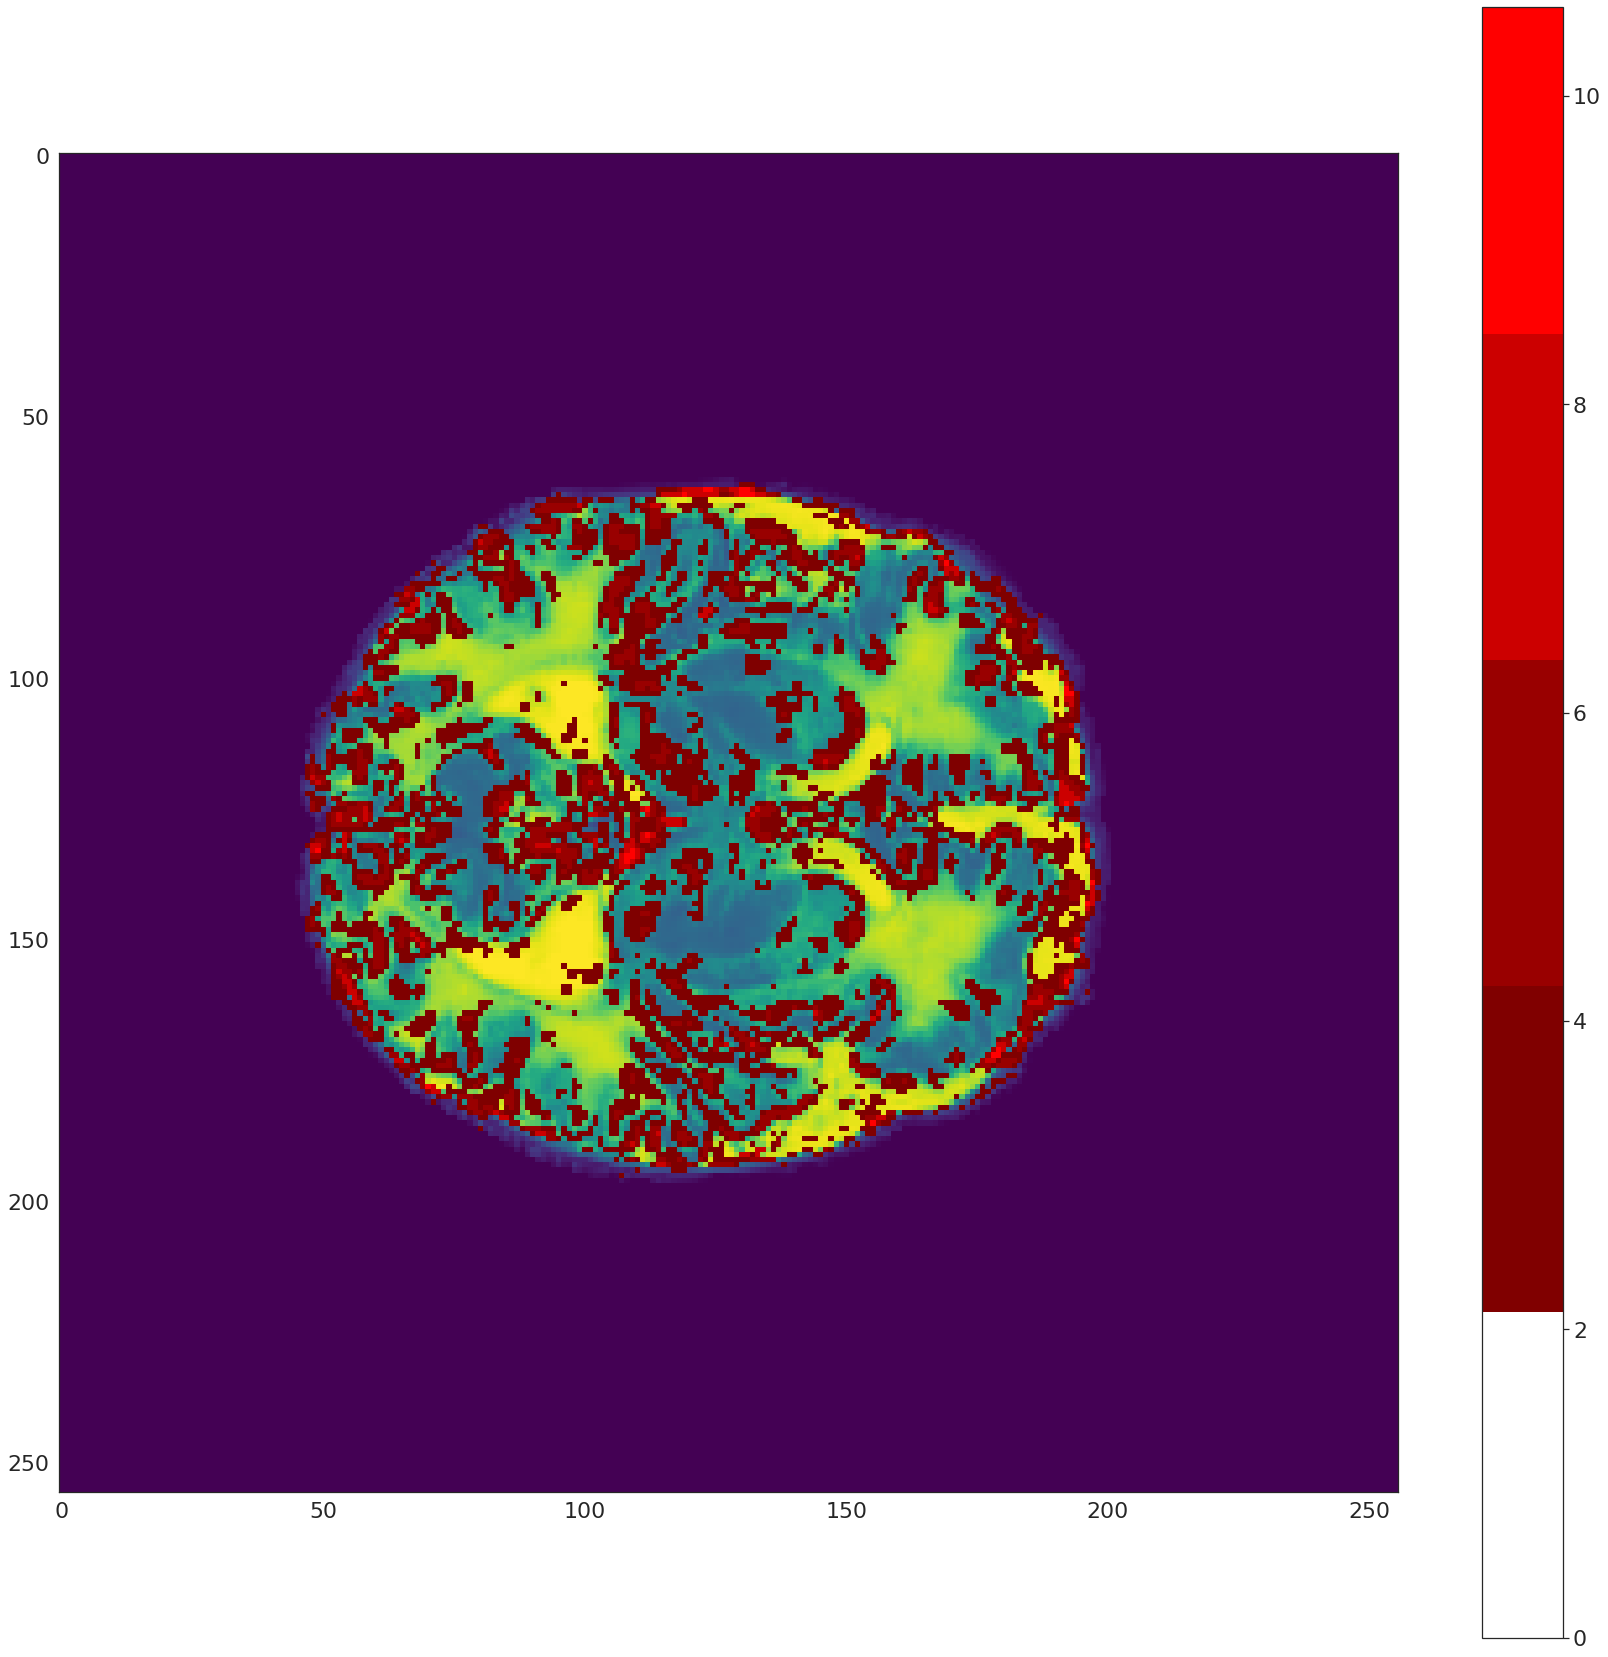

In [26]:
diff_image_viz(np.reshape(normal[0], (x, y, z)), pred_img, 5)

Text(0.5, 1.0, 'Recreated')

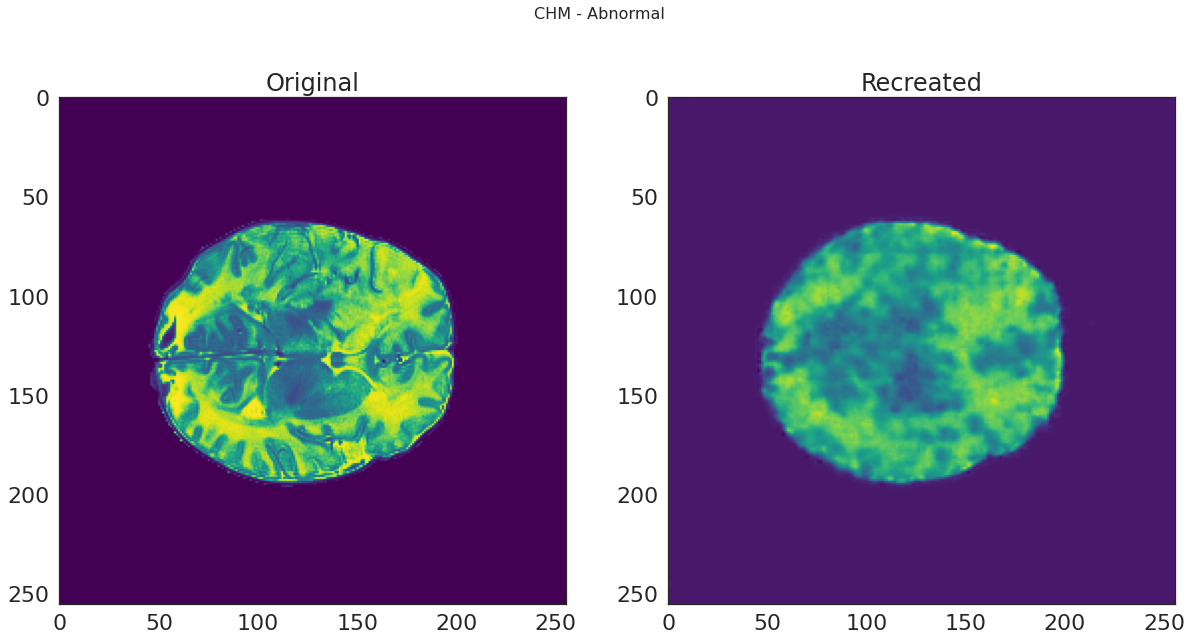

In [27]:
# predict image
pred_img = model.predict(np.reshape(abnormal[0], (1, x, y, z, 1)))
pred_img = np.reshape(pred_img, (x, y, z))

# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,10))

z_plot = ceil(pred_img.shape[2]/2)
f.suptitle('CHM - Abnormal', fontsize=16)
axarr[0].imshow(np.reshape(abnormal[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1].set_title('Recreated')

0.07130123238577642


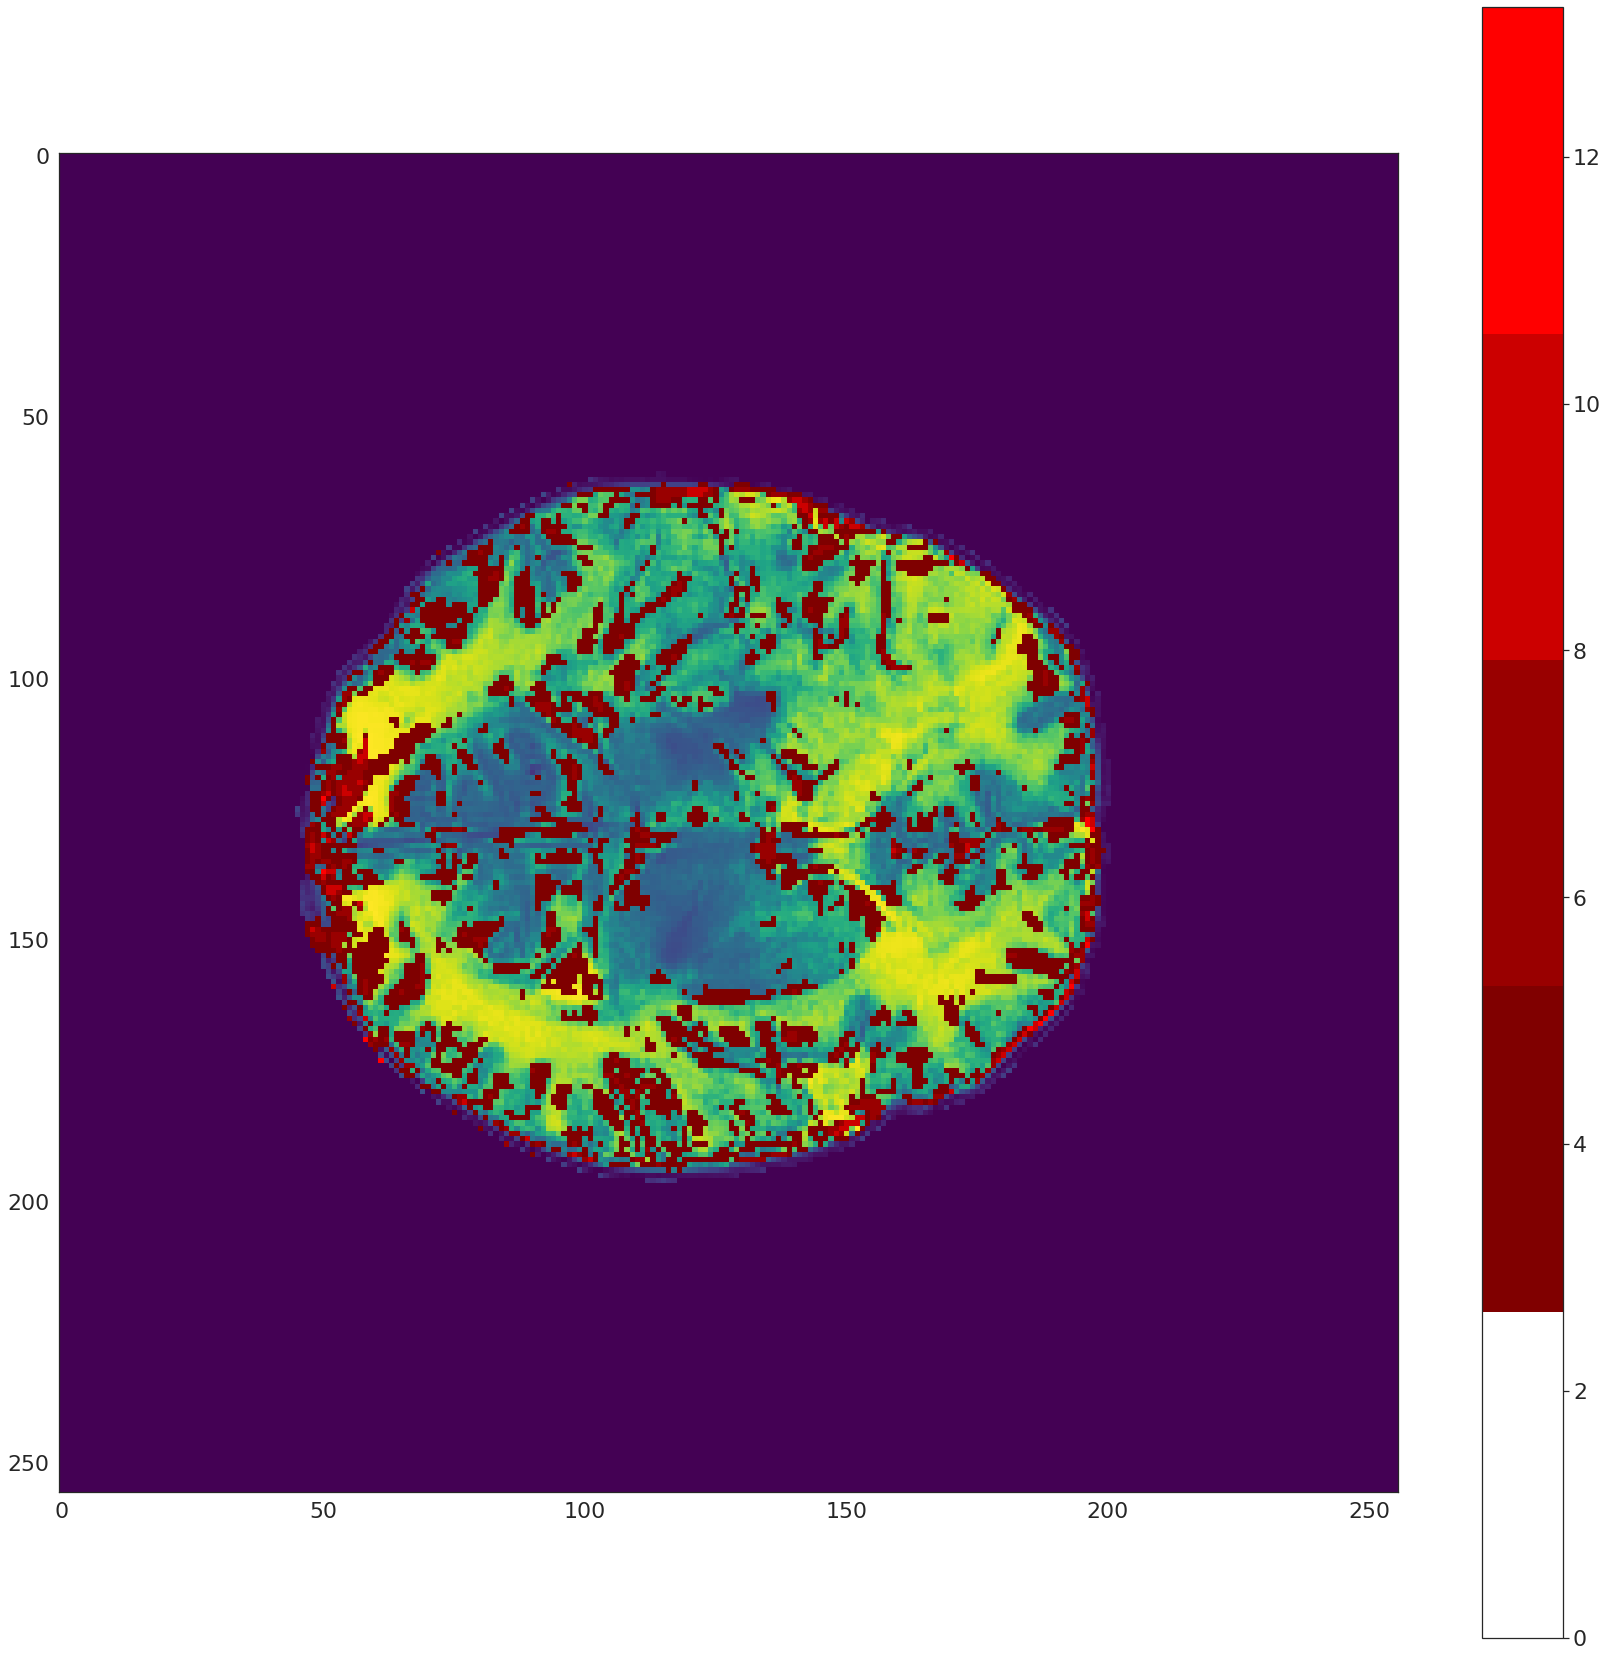

In [28]:
diff_image_viz(np.reshape(abnormal[0], (x, y, z)), pred_img, 5)

Text(0.5, 1.0, 'Recreated')

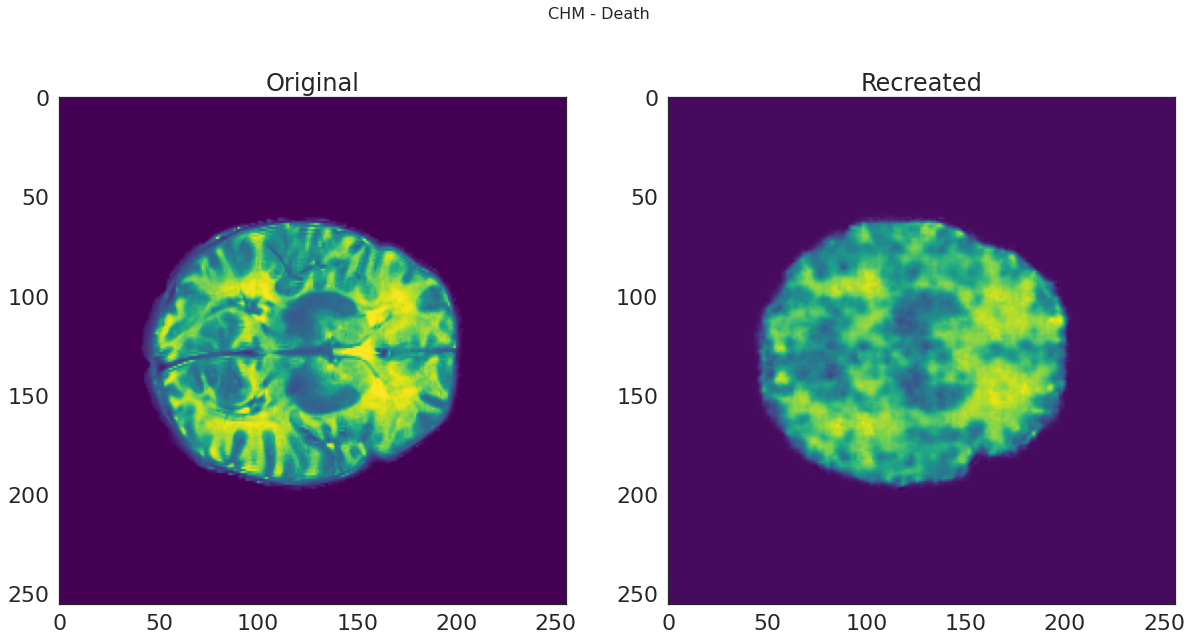

In [29]:
# predict image
pred_img = model.predict(np.reshape(death[0], (1, x, y, z, 1)))
pred_img = np.reshape(pred_img, (x, y, z))

# plot original and new image
f, axarr = plt.subplots(1, 2, figsize=(20,10))

z_plot = ceil(pred_img.shape[2]/2)
#z_plot = 100
f.suptitle('CHM - Death', fontsize=16)
axarr[0].imshow(np.reshape(death[0][:,:,z_plot], (x, y)), cmap=cmap)
axarr[0].set_title('Original')
axarr[1].imshow(pred_img[:,:,z_plot], cmap=cmap)
axarr[1].set_title('Recreated')

0.05945013697074888


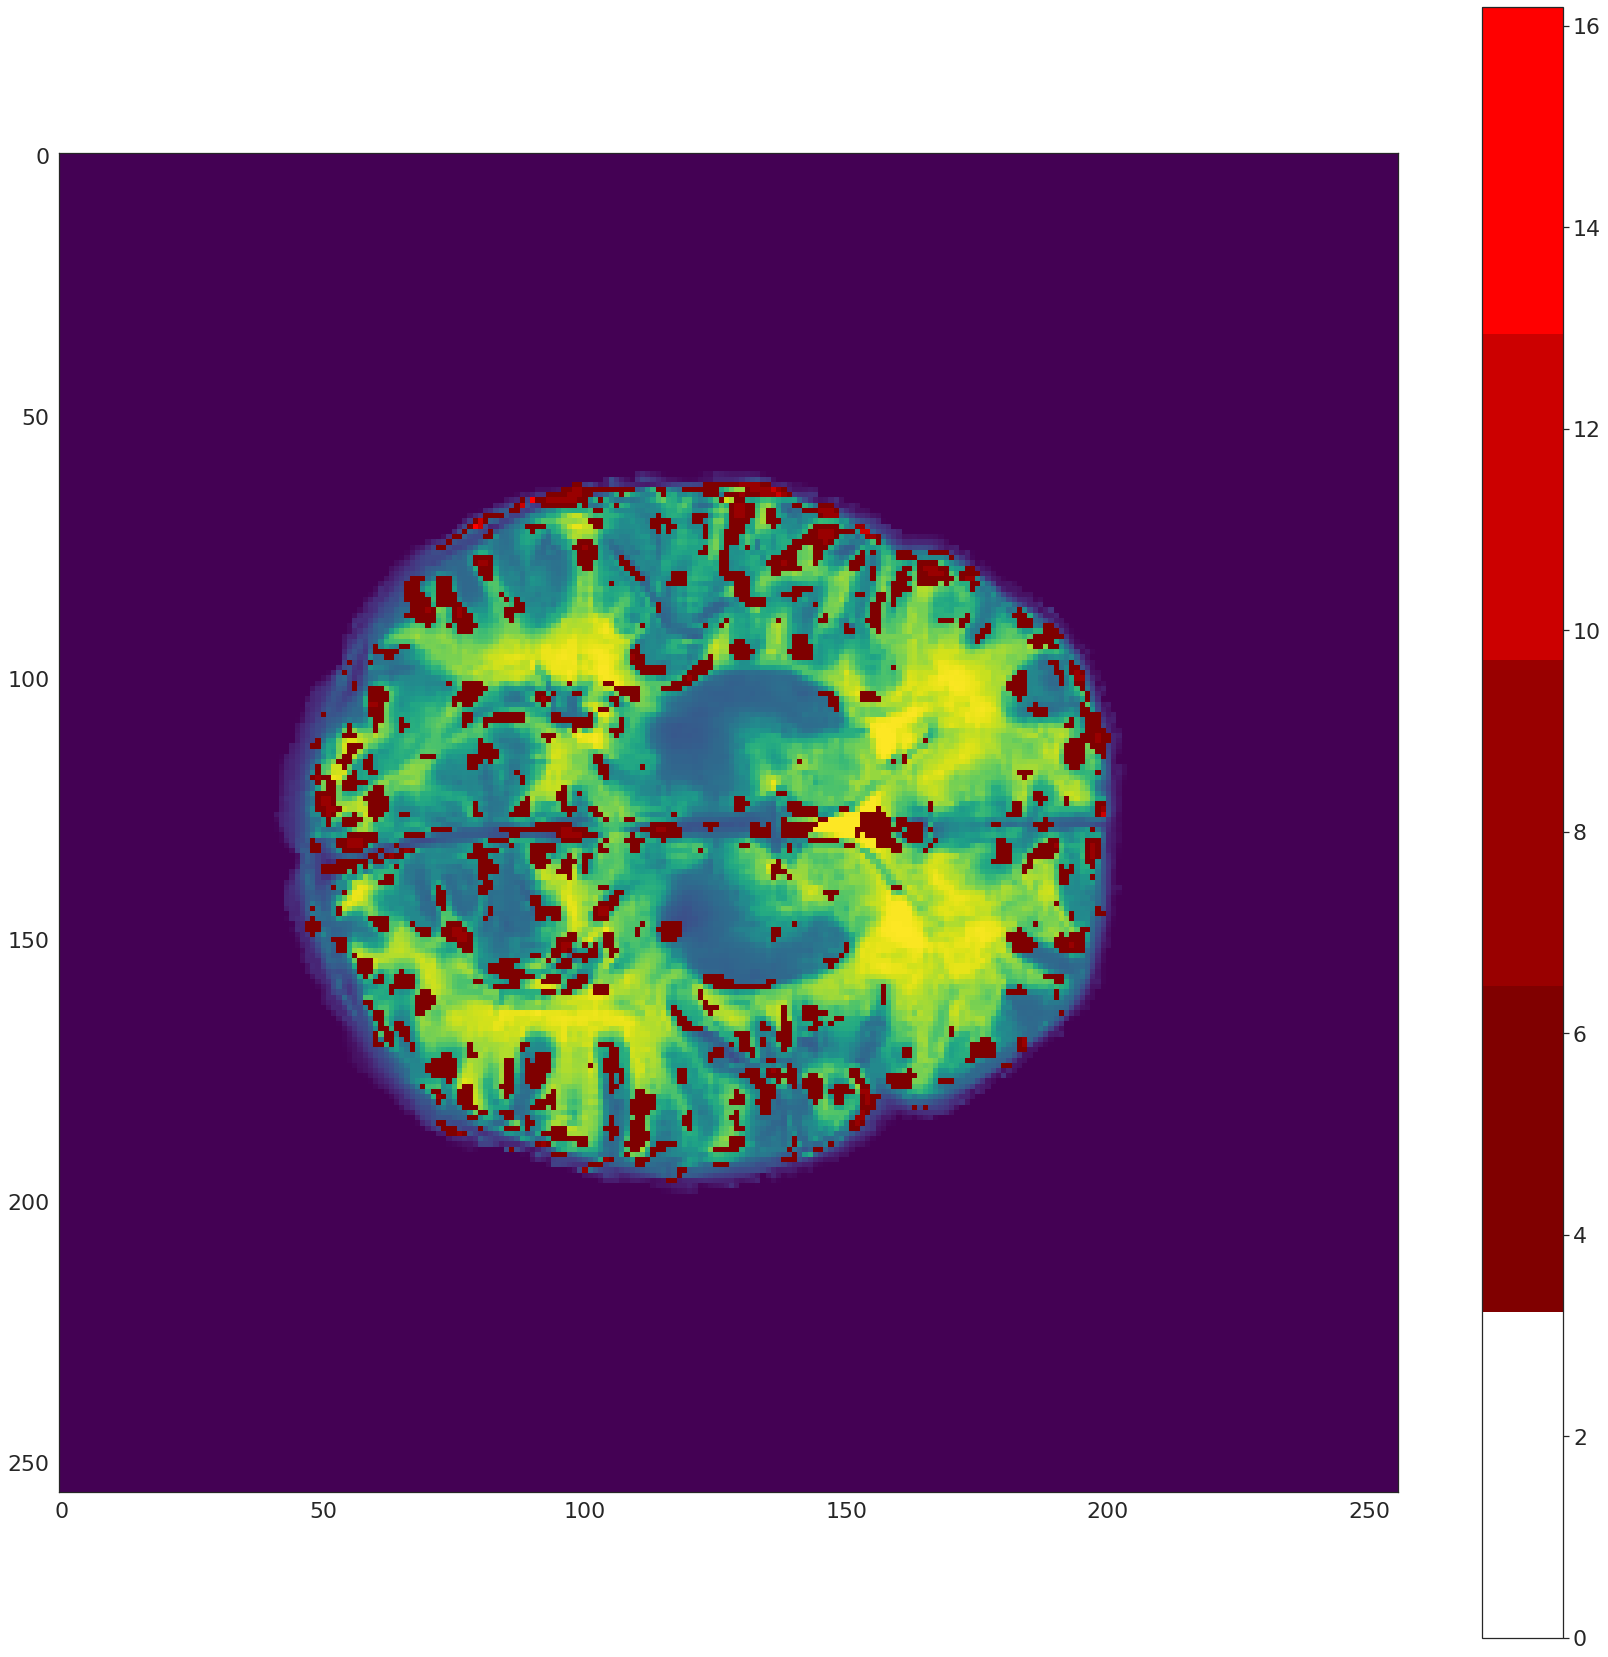

In [30]:
diff_image_viz(np.reshape(death[0], (x, y, z)), pred_img, 5)